# CS435 Term Project

## Analyze Crime Rates to Help Mitigate Crimes in Chicago

Team Members: Jimit Bhalavat, Logan Cuccia, Kyle Cummings, Mike Peyton

### Description

Chicago was once a pillar of prosperity and trade where companies housed their headquarters, where business partners formed coalitions, and where impactful business decisions were made. Today, it is still a major capital for trade, and some areas are very prosperous. Other sectors are rampant with crime, murder, theft, break-ins, and kidnappings. The crimes within some Chicago districts are so high that officers often don’t know whether they will return home that day to their families. Although there are countless factors contributing to the growing crime rate and law enforcement procedures, crimes are overwhelmingly complex and have to do with politics, state, and local government actions. The question arises how has crime changed over the years? Is it possible to predict where or when a crime will be committed? Which areas of the city have evolved over this time span?

The goal of this project is to tackle how we can use data from these crimes to potentially stop them from becoming so frequent. It will also provide data summarizations such as the location and frequency of the crimes, and the nature of the crimes which can ultimately help mitigate crimes and help law enforcement agencies pinpoint where these crimes are more likely to occur, and which districts should have a higher abundance of police officers. This information can not only save the lives of citizens but also police officers who risk their lives every day to better their communities. It also ensures that these criminals have a higher likelihood of being caught since so many crimes in these districts go unsolved. The dataset contains attributes such as date, coordinates of the incident, district, the nature of the crime, etc. We will attempt to use these attributes to generate summarizations that will assist in the fight against crime as well as assist in the city’s economic future. 

### Goal of the Project

In order to solve this problem and help aid law enforcement agencies in Chicago, we will aim to analyze this dataset and run a variety of different processing techniques and models in order to interpret results and answer the questions mentioned above. This dataset is large and contains various attributes, so it is complex to analyze through normal methods. In order to process this data effectively and efficiently, we will use MapReduce to process the data and provide numerical summarizations such as the accuracy rates of prediction through Neural Networks, Random Forests, and K Means clustering. Other numerical summarizations will include the proportions of arrests made by the crimes committed, whether the trends in crimes have increased over the years, and if yes, what crimes are more likely to be committed. 


In this project, we aim to analyze the relationship between different types of crimes and the location they happened. In our research, we also aim to analyze the statistics of a few specific crimes: theft, homicide, and sexual harassment, and whether these crimes have declined or increased over the years. We aim to use a few of the packages available in Python3 such as Pandas (Dataframe), Numpy (Math), Seaborn and Matplotlib (Data Visualization), and Sklearn (Algorithms). The framework we plan to use is Hadoop or Spark. 


### Data Description

The dataset comes from Kaggle and reflects the reported incidents of crime in the City of Chicago from 2001 to 2017. The set excludes murders where data exists for each victim. This dataset is withdrawn from the Chicago Police Department’s Citizen Law Enforcement Analysis and Reporting System. The entire dataset spans around 2GB. In order to span the 16 years of data, the entire dataset has been broken down into four different CSV files. The entries of the files have attributes such as a unique identifier, block where the incident occurred, description of the location where the incident occurred, whether the incident was domestic-related, police district where the incident occurred, latitude, and longitude of the incident, to name a few. To protect the privacy of crime victims, the exact addresses of the crimes are not shared, but the location data included will allow us to pinpoint the general location of the crime. We can use the description attributes to categorize what type of crime was committed, and also filter based on other attributes such as whether an arrest was made, or whether the case was domestic.

In [29]:
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
from datetime import datetime

### Data Processing

In [30]:
dt_string = "09/05/2015 01:30:00 PM"

# Considering date is in dd/mm/yyyy format
dt_object1 = datetime.strptime(dt_string, "%d/%m/%Y %H:%M:%S %p")
print("dt_object1 =", dt_object1)


dt_object1 = 2015-05-09 01:30:00


In [31]:
crimes_temp = pd.read_csv("../Crimes_-_2001_to_Present.csv")
crimes_temp.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Longitude,Location,Historical Wards 2003-2015,Zip Codes,Community Areas,Census Tracts,Wards,Boundaries - ZIP Codes,Police Districts,Police Beats
0,10224738,HY411648,09/05/2015 01:30:00 PM,043XX S WOOD ST,0486,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,...,-87.670000,"(41.815117282, -87.669999562)",29.0,14924.0,59.0,706.0,3.0,37.0,23.0,108.0
1,10224739,HY411615,09/04/2015 11:30:00 AM,008XX N CENTRAL AVE,0870,THEFT,POCKET-PICKING,CTA BUS,False,False,...,-87.765400,"(41.895080471, -87.765400451)",4.0,4299.0,26.0,562.0,45.0,5.0,25.0,67.0
2,11646166,JC213529,09/01/2018 12:01:00 AM,082XX S INGLESIDE AVE,0810,THEFT,OVER $500,RESIDENCE,False,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10224740,HY411595,09/05/2015 12:45:00 PM,035XX W BARRY AVE,2023,NARCOTICS,POSS: HEROIN(BRN/TAN),SIDEWALK,True,False,...,-87.716650,"(41.937405765, -87.716649687)",15.0,21538.0,22.0,216.0,12.0,39.0,7.0,168.0
4,10224741,HY411610,09/05/2015 01:00:00 PM,0000X N LARAMIE AVE,0560,ASSAULT,SIMPLE,APARTMENT,False,True,...,-87.755121,"(41.881903443, -87.755121152)",11.0,22216.0,26.0,696.0,23.0,32.0,25.0,81.0


In [32]:
crimes = crimes_temp.drop(['IUCR', 'FBI Code', 'X Coordinate','Y Coordinate', 'Updated On', 'Location', 'Location Description'], axis = 1)
crimes = crimes.dropna()
crimes.isnull().sum()
crimes.head()

,ID,Case Number,Date,Block,Primary Type,Description,Arrest,Domestic,Beat,District,...,Latitude,Longitude,Historical Wards 2003-2015,Zip Codes,Community Areas,Census Tracts,Wards,Boundaries - ZIP Codes,Police Districts,Police Beats
0,10224738,HY411648,09/05/2015 01:30:00 PM,043XX S WOOD ST,BATTERY,DOMESTIC BATTERY SIMPLE,False,True,924,9.0,...,41.815117,-87.670000,29.0,14924.0,59.0,706.0,3.0,37.0,23.0,108.0
1,10224739,HY411615,09/04/2015 11:30:00 AM,008XX N CENTRAL AVE,THEFT,POCKET-PICKING,False,False,1511,15.0,...,41.895080,-87.765400,4.0,4299.0,26.0,562.0,45.0,5.0,25.0,67.0
3,10224740,HY411595,09/05/2015 12:45:00 PM,035XX W BARRY AVE,NARCOTICS,POSS: HEROIN(BRN/TAN),True,False,1412,14.0,...,41.937406,-87.716650,15.0,21538.0,22.0,216.0,12.0,39.0,7.0,168.0
4,10224741,HY411610,09/05/2015 01:00:00 PM,0000X N LARAMIE AVE,ASSAULT,SIMPLE,False,True,1522,15.0,...,41.881903,-87.755121,11.0,22216.0,26.0,696.0,23.0,32.0,25.0,81.0
5,10224742,HY411435,09/05/2015 10:55:00 AM,082XX S LOOMIS BLVD,BURGLARY,FORCIBLE ENTRY,False,False,614,6.0,...,41.744379,-87.658431,18.0,21554.0,70.0,575.0,13.0,59.0,20.0,237.0


In [34]:
crimes['Description'] = crimes['Description'].str.replace(',', '/')

### Map Reduce

### Neural Networks

In [55]:
from numpy import loadtxt
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split

In [56]:
# Convert Categorical Attributes to Numerical
crimes['Block'] = pd.factorize(crimes["Block"])[0]
crimes['Description'] = pd.factorize(crimes["Description"])[0]

Target:  Primary Type


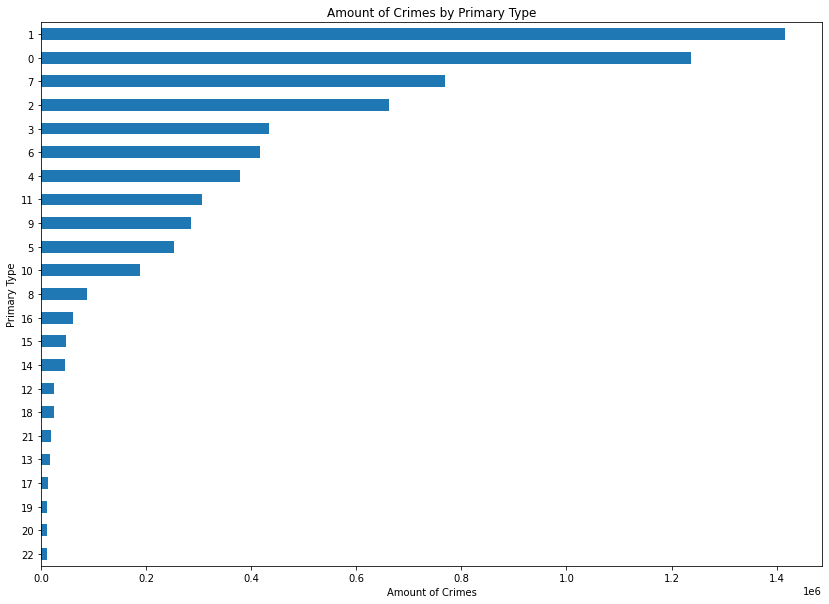

In [57]:
Target = 'Primary Type'
print('Target: ', Target)

plt.figure(figsize=(14,10))
plt.title('Amount of Crimes by Primary Type')
plt.ylabel('Crime Type')
plt.xlabel('Amount of Crimes')

crimes.groupby([crimes['Primary Type']]).size().sort_values(ascending=True).plot(kind='barh')

plt.show()

In [58]:
all_classes = crimes.groupby(['Primary Type'])['Block'].size().reset_index()
all_classes['Amt'] = all_classes['Block']
all_classes = all_classes.drop(['Block'], axis=1)
all_classes = all_classes.sort_values(['Amt'], ascending=[False])

unwanted_classes = all_classes.tail(13)
unwanted_classes

,Primary Type,Amt
10,10,189135
8,8,87675
16,16,60817
15,15,47517
14,14,46461
12,12,24535
18,18,24203
21,21,19283
13,13,17150
17,17,13372


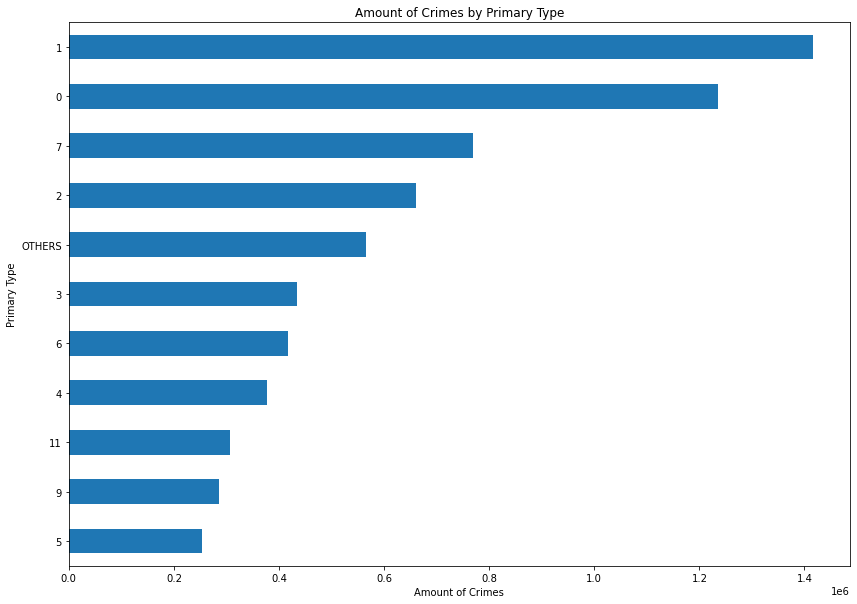

In [59]:
# After that, we replaced it with label 'OTHERS'
crimes.loc[crimes['Primary Type'].isin(unwanted_classes['Primary Type']), 'Primary Type'] = 'OTHERS'

# Plot Bar Chart visualize Primary Types
plt.figure(figsize=(14,10))
plt.title('Amount of Crimes by Primary Type')
plt.ylabel('Crime Type')
plt.xlabel('Amount of Crimes')

crimes.groupby([crimes['Primary Type']]).size().sort_values(ascending=True).plot(kind='barh')

plt.show()

In [60]:
# Now we are left with 14 Class as our predictive class
Classes = crimes['Primary Type'].unique()
Classes

array([0, 1, 2, 3, 4, 5, 6, 7, 'OTHERS', 9, 11], dtype=object)

In [61]:
crimes['Primary Type'] = pd.factorize(crimes["Primary Type"])[0] 
crimes['Primary Type'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [62]:
# Feature Selection using Filter Method 
# Split Dataframe to target class and features
X_fs = crimes.drop(['Primary Type'], axis=1)
Y_fs = crimes['Primary Type']

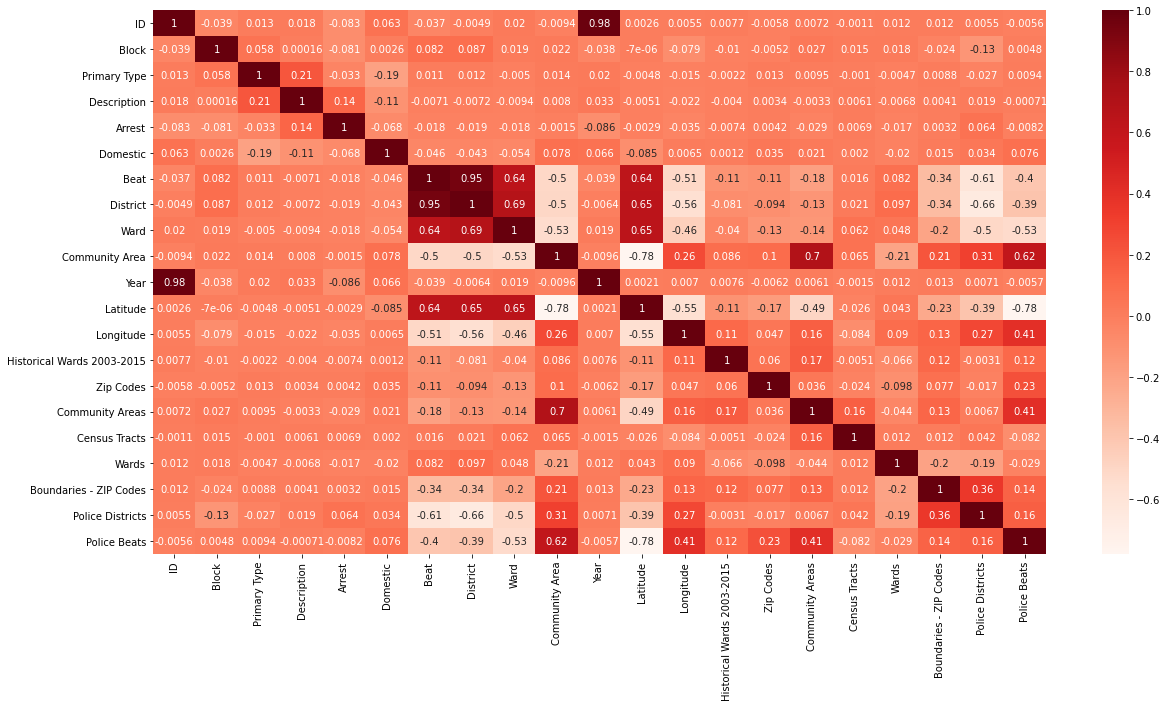

In [63]:
#Using Pearson Correlation
plt.figure(figsize=(20,10))
cor = crimes.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [64]:
# At Current Point, the attributes is select manually based on Feature Selection Part. 
Features = ["Block"]
print('Full Features: ', Features)

Full Features:  ['Block', 'Description']


In [65]:
#Split dataset to Training Set & Test Set
x, y = train_test_split(crimes, 
                        test_size = 0.2, 
                        train_size = 0.8, 
                        random_state= 3)

x1 = x[Features]    #Features to train
x2 = x[Target]      #Target Class to train
y1 = y[Features]    #Features to test
y2 = y[Target]      #Target Class to test

print('Feature Set Used    : ', Features)
print('Target Class        : ', Target)
print('Training Set Size   : ', x.shape)
print('Test Set Size       : ', y.shape)

Feature Set Used    :  ['Block', 'Description']
Target Class        :  Primary Type
Training Set Size   :  (5378564, 23)
Test Set Size       :  (1344641, 23)


In [66]:
network1 = Sequential()
network1.add(Dense(10, activation='relu'))
network1.add(Dense(1))
loss_fn = keras.losses.MeanSquaredError()
opt = keras.optimizers.SGD(learning_rate=0.005)
network1.compile(loss=loss_fn, optimizer=opt, metrics=['accuracy', 'mse'])
n_epochs = 512
history1 = network1.fit(x1, x2, batch_size=2, epochs=n_epochs, verbose=1)

Epoch 1/512
 135495/2689282 [>.............................] - ETA: 1:01:32 - loss: nan - accuracy: 0.1850 - mse: nan

KeyboardInterrupt: 

### K-Means Clustering

### Random Forests

In [10]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
from pyspark.sql.functions import format_number, when, col, array, udf, lit
import pandas as pd
from pyspark.ml.feature import VectorAssembler, StringIndexer, VectorIndexer, IndexToString
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.sql.types import *
import pyspark.sql.functions as F
import matplotlib.pyplot as plt

In [11]:

spark = SparkSession.builder.appName("Project - Chicago crime").config("spark.some.config.option", "some-value").config("spark.driver.memory", "8g").config("spark.driver.cores", "3").getOrCreate()

RuntimeError: Java gateway process exited before sending its port number

In [4]:

crimes_schema = StructType([StructField("ID", StringType(), True),
                            StructField("Case Number", StringType(), True),
                            StructField("Date", StringType(), True ),
                            StructField("Block", StringType(), True),
                            StructField("IUCR", StringType(), True),
                            StructField("Primary Type", StringType(), True  ),
                            StructField("Description", StringType(), True ),
                            StructField("Location Description", StringType(), True ),
                            StructField("Arrest", BooleanType(), True),
                            StructField("Domestic", BooleanType(), True),
                            StructField("Beat", StringType(), True),
                            StructField("District", StringType(), True),
                            StructField("Ward", StringType(), True),
                            StructField("Community Area", StringType(), True),
                            StructField("FBI Code", StringType(), True ),
                            StructField("X Coordinate", DoubleType(), True),
                            StructField("Y Coordinate", DoubleType(), True ),
                            StructField("Year", IntegerType(), True),
                            StructField("Updated On", DateType(), True ),
                            StructField("Latitude", DoubleType(), True),
                            StructField("Longitude", DoubleType(), True),
                            StructField("Location", StringType(), True )
                            ])

In [5]:
dataset = spark.read.option("header", "True").option("inferSchema", "true").csv("../Crimes_-_2001_to_present.csv")

In [6]:
dataset.limit(5).toPandas().head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,10224738,HY411648,09/05/2015 01:30:00 PM,043XX S WOOD ST,0486,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,...,12,61,08B,1165074.0,1875917.0,2015,02/10/2018 03:50:01 PM,41.815117,-87.670000,"(41.815117282, -87.669999562)"
1,10224739,HY411615,09/04/2015 11:30:00 AM,008XX N CENTRAL AVE,0870,THEFT,POCKET-PICKING,CTA BUS,False,False,...,29,25,06,1138875.0,1904869.0,2015,02/10/2018 03:50:01 PM,41.895080,-87.765400,"(41.895080471, -87.765400451)"
2,11646166,JC213529,09/01/2018 12:01:00 AM,082XX S INGLESIDE AVE,0810,THEFT,OVER $500,RESIDENCE,False,True,...,8,44,06,NaN,NaN,2018,04/06/2019 04:04:43 PM,NaN,NaN,None
3,10224740,HY411595,09/05/2015 12:45:00 PM,035XX W BARRY AVE,2023,NARCOTICS,POSS: HEROIN(BRN/TAN),SIDEWALK,True,False,...,35,21,18,1152037.0,1920384.0,2015,02/10/2018 03:50:01 PM,41.937406,-87.716650,"(41.937405765, -87.716649687)"
4,10224741,HY411610,09/05/2015 01:00:00 PM,0000X N LARAMIE AVE,0560,ASSAULT,SIMPLE,APARTMENT,False,True,...,28,25,08A,1141706.0,1900086.0,2015,02/10/2018 03:50:01 PM,41.881903,-87.755121,"(41.881903443, -87.755121152)"


In [7]:
dataset = dataset.filter((dataset['Primary Type']!='STALKING')&
                             (dataset['Primary Type']!='OBSCENITY')&
                             (dataset['Primary Type']!='NON-CRIMINAL (SUBJECT SPECIFIED)')&
                             (dataset['Primary Type']!='GAMBLING')&
                             (dataset['Primary Type']!='NON - CRIMINAL')&
                             (dataset['Primary Type']!='LIQUOR LAW VIOLATION')&
                             (dataset['Primary Type']!='PUBLIC INDECENCY')&
                             (dataset['Primary Type']!='HUMAN TRAFFICKING')&
                             (dataset['Primary Type']!='INTIMIDATION')&
                             (dataset['Primary Type']!='CONCEALED CARRY LICENSE VIOLATION')&
                             (dataset['Primary Type']!='NON-CRIMINAL')&
                             (dataset['Primary Type']!='OTHER NARCOTIC VIOLATION'))

In [8]:

dataset = dataset.withColumn("Day", F.split(dataset.Date, " ")[0])
dataset = dataset.withColumn("Day", F.to_date(dataset.Day, "MM/dd/yyyy"))
dataset = dataset.withColumn("Month", F.month(dataset.Day))
dataset = dataset.withColumn("WeekDay", F.dayofweek(dataset.Day))
dataset = dataset.withColumn("Hour", F.split(F.split(dataset.Date," ")[1], ":")[0].cast("int"))
dataset = dataset.na.drop()
dataset.limit(5).toPandas().head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Y Coordinate,Year,Updated On,Latitude,Longitude,Location,Day,Month,WeekDay,Hour
0,10224738,HY411648,09/05/2015 01:30:00 PM,043XX S WOOD ST,0486,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,...,1875917,2015,02/10/2018 03:50:01 PM,41.815117,-87.670000,"(41.815117282, -87.669999562)",2015-09-05,9,7,1
1,10224739,HY411615,09/04/2015 11:30:00 AM,008XX N CENTRAL AVE,0870,THEFT,POCKET-PICKING,CTA BUS,False,False,...,1904869,2015,02/10/2018 03:50:01 PM,41.895080,-87.765400,"(41.895080471, -87.765400451)",2015-09-04,9,6,11
2,10224740,HY411595,09/05/2015 12:45:00 PM,035XX W BARRY AVE,2023,NARCOTICS,POSS: HEROIN(BRN/TAN),SIDEWALK,True,False,...,1920384,2015,02/10/2018 03:50:01 PM,41.937406,-87.716650,"(41.937405765, -87.716649687)",2015-09-05,9,7,12
3,10224741,HY411610,09/05/2015 01:00:00 PM,0000X N LARAMIE AVE,0560,ASSAULT,SIMPLE,APARTMENT,False,True,...,1900086,2015,02/10/2018 03:50:01 PM,41.881903,-87.755121,"(41.881903443, -87.755121152)",2015-09-05,9,7,1
4,10224742,HY411435,09/05/2015 10:55:00 AM,082XX S LOOMIS BLVD,0610,BURGLARY,FORCIBLE ENTRY,RESIDENCE,False,False,...,1850165,2015,02/10/2018 03:50:01 PM,41.744379,-87.658431,"(41.744378879, -87.658430635)",2015-09-05,9,7,10


In [9]:

dataset = dataset.withColumn("Primary Type", \
                               when((dataset["Primary Type"] == 'CRIM SEXUAL ASSAULT') | \
                                    (dataset["Primary Type"] == 'PROSTITUTION') ,'SEX OFFENSE').otherwise(dataset['Primary Type']))
dataset = dataset.withColumn("Primary Type", \
                               when((dataset["Primary Type"] == 'WEAPONS VIOLATION') | \
                                    (dataset["Primary Type"] == 'INTERFERENCE WITH PUBLIC OFFICER') ,'PUBLIC PEACE VIOLATION').otherwise(dataset['Primary Type']))
dataset = dataset.withColumn("Primary Type", \
                               when((dataset["Primary Type"] == 'ARSON') ,'CRIMINAL TRESPASS').otherwise(dataset['Primary Type']))

In [10]:
dataset = dataset.na.drop()
dataset = dataset.drop('ID')
dataset = dataset.drop('Case Number')
dataset = dataset.drop('Block')
dataset = dataset.drop('IUCR')
dataset = dataset.drop('FBI Code')
dataset = dataset.drop('Updated On')
dataset = dataset.drop('X Coordinate')
dataset = dataset.drop('Y Coordinate')
dataset = dataset.drop('Description')
dataset = dataset.drop('Location')
dataset = dataset.drop('Date')
dataset.limit(5).toPandas().head(5)

,Primary Type,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,Year,Latitude,Longitude,Day,Month,WeekDay,Hour
0,BATTERY,RESIDENCE,False,True,924,9,12,61,2015,41.815117,-87.670000,2015-09-05,9,7,1
1,THEFT,CTA BUS,False,False,1511,15,29,25,2015,41.895080,-87.765400,2015-09-04,9,6,11
2,NARCOTICS,SIDEWALK,True,False,1412,14,35,21,2015,41.937406,-87.716650,2015-09-05,9,7,12
3,ASSAULT,APARTMENT,False,True,1522,15,28,25,2015,41.881903,-87.755121,2015-09-05,9,7,1
4,BURGLARY,RESIDENCE,False,False,614,6,21,71,2015,41.744379,-87.658431,2015-09-05,9,7,10


In [11]:
vector_assembler = VectorAssembler(inputCols = ["Latitude", "Longitude"], outputCol="features")
df_temp = vector_assembler.transform(dataset)
featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures").fit(df_temp)


labelIndexer = StringIndexer(inputCol="Primary Type", outputCol="indexedLabel").fit(df_temp)
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel", labels=labelIndexer.labels)


(trainingData, testData) = df_temp.randomSplit([0.7, 0.3])
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=10,impurity='gini', maxBins=32)

pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf,labelConverter])

model = pipeline.fit(trainingData)

predictions = model.transform(testData)

evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
evaluator2 = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="f1")

accuracy = evaluator.evaluate(predictions)
f1 = evaluator2.evaluate(predictions)


print("accuracy = %g" % (accuracy))
print("f1 score = %g" % (f1))

predictions.groupBy("predictedLabel").count().show()

accuracy = 0.253501
f1 score = 0.167548
+--------------+-------+
|predictedLabel|  count|
+--------------+-------+
|         THEFT| 767704|
|       BATTERY|1064086|
|     NARCOTICS| 179466|
+--------------+-------+



In [12]:
from pyspark.ml.feature import OneHotEncoder
locationIndexer = StringIndexer(inputCol="Location Description", outputCol="indexedLocation").fit(dataset).transform(dataset)
encoded_data = OneHotEncoder(inputCols=["indexedLocation"],outputCols=["encodedLocation"]).fit(locationIndexer).transform(locationIndexer)

In [13]:

vector_assembler = VectorAssembler(inputCols = ["Latitude", "Longitude", "Arrest", "Beat", "Ward", "Community Area", "WeekDay", "Hour", "encodedLocation"], outputCol="features")
df_temp = vector_assembler.transform(encoded_data)
featureIndexer =VectorIndexer(inputCol="features", outputCol="indexedFeatures").fit(df_temp)

labelIndexer = StringIndexer(inputCol="Primary Type", outputCol="indexedLabel").fit(df_temp)
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",labels=labelIndexer.labels)

(trainingData, testData) = df_temp.randomSplit([0.7, 0.3])
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=10,impurity='gini', maxBins=32)

pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf,labelConverter])

model = pipeline.fit(trainingData)

predictions = model.transform(testData)

evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
evaluator2 = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="f1")

accuracy = evaluator.evaluate(predictions)
f1 = evaluator2.evaluate(predictions)

print("accuracy = %g" % (accuracy))
print("f1 score = %g" % (f1))

predictions.groupBy("predictedLabel").count().show()

accuracy = 0.326263
f1 score = 0.207321
+------------------+-------+
|    predictedLabel|  count|
+------------------+-------+
|             THEFT|1317474|
|           BATTERY| 225149|
|DECEPTIVE PRACTICE|   4857|
|         NARCOTICS| 452552|
|          BURGLARY|  12321|
+------------------+-------+



In [14]:

labels = labelIndexer.labels
prediction_probility= predictions.select("predictedLabel", "Primary Type","Latitude","Longitude","probability")

def addCrimeIndex(li):
    dic = {}
    for i in range(len(labels)):
        dic[labels[i]]=li[i]
    return dic

probability_to_array = udf(lambda v: v.toArray().tolist(), ArrayType(FloatType()))
prediction_probility = prediction_probility.withColumn('probability', probability_to_array(prediction_probility.probability))

probability_to_dict = udf(addCrimeIndex)

prediction_probility = prediction_probility.withColumn('probability', probability_to_dict(prediction_probility.probability))

pd.set_option('display.max_colwidth', -1)
prediction_probility.limit(5).toPandas().head(5)

<ipython-input-14-316685dff4a7>:17: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,predictedLabel,Primary Type,Latitude,Longitude,probability
0,NARCOTICS,ASSAULT,41.762366,-87.666178,"{HOMICIDE=0.00247052925621227, BATTERY=0.1650196700726889, ROBBERY=0.027687703059841987, SEX OFFENSE=0.027644620655851396, OFFENSE INVOLVING CHILDREN=0.005796728926257566, CRIMINAL SEXUAL ASSAULT=2.954517120817518E-4, NARCOTICS=0.2491775648034916, CRIMINAL TRESPASS=0.05371008951982628, RITUALISM=2.107807781703833E-6, CRIMINAL DAMAGE=0.06980701187365011, DECEPTIVE PRACTICE=0.03095496746317942, OTHER OFFENSE=0.051776479953643074, PUBLIC PEACE VIOLATION=0.04744099709520571, ASSAULT=0.06153801596097227, MOTOR VEHICLE THEFT=0.03004065908619048, KIDNAPPING=5.974501196136689E-4, BURGLARY=0.03271755786315021, THEFT=0.1433223947703612}"
1,THEFT,ASSAULT,41.785039,-87.751886,"{HOMICIDE=0.001400578109662531, BATTERY=0.18933544672907326, ROBBERY=0.04346708127458252, SEX OFFENSE=0.012757005784434535, OFFENSE INVOLVING CHILDREN=0.007664654548106202, CRIMINAL SEXUAL ASSAULT=5.821237689066773E-4, NARCOTICS=0.05716919039295567, CRIMINAL TRESPASS=0.02321430712597461, RITUALISM=2.589158458028279E-6, CRIMINAL DAMAGE=0.12546858719631956, DECEPTIVE PRACTICE=0.04714659108736309, OTHER OFFENSE=0.06772619764339514, PUBLIC PEACE VIOLATION=0.01606973501679868, ASSAULT=0.06949316669178543, MOTOR VEHICLE THEFT=0.04489784585700226, KIDNAPPING=9.956322674801424E-4, BURGLARY=0.06571965505534037, THEFT=0.22688961229236146}"
2,THEFT,ASSAULT,41.976290,-87.905227,"{HOMICIDE=0.0012789687620909462, BATTERY=0.1817678632828756, ROBBERY=0.04086866355392008, SEX OFFENSE=0.012027281670352462, OFFENSE INVOLVING CHILDREN=0.007021496956973873, CRIMINAL SEXUAL ASSAULT=6.176782961229925E-4, NARCOTICS=0.048570823316020015, CRIMINAL TRESPASS=0.022259457122416663, RITUALISM=2.0299717806576916E-6, CRIMINAL DAMAGE=0.12578723552662982, DECEPTIVE PRACTICE=0.05085025606696275, OTHER OFFENSE=0.06729749479022581, PUBLIC PEACE VIOLATION=0.0142988249629025, ASSAULT=0.06522369577691448, MOTOR VEHICLE THEFT=0.0461551063236598, KIDNAPPING=9.406112298588918E-4, BURGLARY=0.06458541789216962, THEFT=0.25044709449812286}"
3,THEFT,ASSAULT,41.978108,-87.904123,"{HOMICIDE=0.0012789687620909462, BATTERY=0.1817678632828756, ROBBERY=0.04086866355392008, SEX OFFENSE=0.012027281670352462, OFFENSE INVOLVING CHILDREN=0.007021496956973873, CRIMINAL SEXUAL ASSAULT=6.176782961229925E-4, NARCOTICS=0.048570823316020015, CRIMINAL TRESPASS=0.022259457122416663, RITUALISM=2.0299717806576916E-6, CRIMINAL DAMAGE=0.12578723552662982, DECEPTIVE PRACTICE=0.05085025606696275, OTHER OFFENSE=0.06729749479022581, PUBLIC PEACE VIOLATION=0.0142988249629025, ASSAULT=0.06522369577691448, MOTOR VEHICLE THEFT=0.0461551063236598, KIDNAPPING=9.406112298588918E-4, BURGLARY=0.06458541789216962, THEFT=0.25044709449812286}"
4,NARCOTICS,ASSAULT,41.977501,-87.903980,"{HOMICIDE=0.0021519531976560606, BATTERY=0.16370589881521397, ROBBERY=0.025658476586566854, SEX OFFENSE=0.030568078974205777, OFFENSE INVOLVING CHILDREN=0.005688312157828372, CRIMINAL SEXUAL ASSAULT=3.4128558354509287E-4, NARCOTICS=0.2387876829582205, CRIMINAL TRESPASS=0.05283086249980584, RITUALISM=1.2088765975083177E-6, CRIMINAL DAMAGE=0.0715521174309293, DECEPTIVE PRACTICE=0.03786745509579633, OTHER OFFENSE=0.053742990347245764, PUBLIC PEACE VIOLATION=0.04033773603289631, ASSAULT=0.05793481550925693, MOTOR VEHICLE THEFT=0.029268783101511136, KIDNAPPING=6.089626175623471E-4, BURGLARY=0.03559284121900227, THEFT=0.1533605389961596}"
